In [1]:
import load
import models

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
## Load data (just one link)
data = load.traveltimes_onelink(start_date = '2019-01-01', end_date = '2019-04-07')
time_res_mins = 15
preds = 1
lag = 8

X, y, times = load.timeseries(data, lag, preds, time_res_mins)
split_pct = 0.92 ## <- pretty much corresponds to training on 12 weeks and testing on 1
X_train, X_test, y_train, y_test, times_train, times_test = load.split(X, y, times, split_pct)

# Independent Quantile and Mean Prediction

W0911 19:16:37.664589 140735687209856 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0911 19:16:39.215380 140735687209856 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


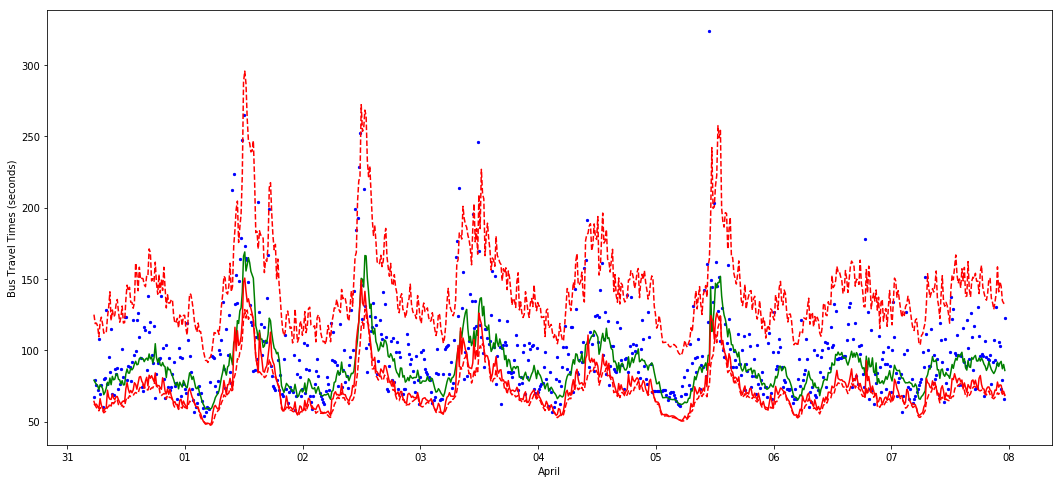

In [3]:
## MEAN ESTIMATION
mod = models.build_model(input_dim = X_train.shape[1], output_dim = 1, loss = 'mse')
mod.fit(X_train, y_train, verbose = 0)
y_pred = mod.predict(X_test)[:,0,0]

## Plot estimated mean
fig, ax = plt.subplots(figsize = (18,8))
plt.ylabel("Bus Travel Times (seconds)")
plt.xlabel("April")
plt.plot(times_test, y_pred, c = 'g')
ax.xaxis.set_major_formatter(DateFormatter("%d"))

## QUANTILE ESTIMATION
quantiles = np.array([0.05, 0.50, 0.95])
## Stores the quantile predictions
y_pred_quan = np.zeros((X_test.shape[0], len(quantiles)))

for q_int in range(len(quantiles)):
    mod = models.build_model(input_dim = X_train.shape[1], 
                             output_dim = 1, 
                             loss = lambda y,f: models.tilted_loss(quantiles[q_int],y,f))
    mod.fit(X_train, y_train, verbose = 0)
    y_pred_quan[:,q_int] = mod.predict(X_test)[:,0,0]
    
    ## Plot estimated quantiles (different colour and style for median)
    if (quantiles[q_int] == 0.50):
        plt.plot(times_test, y_pred_quan[:,q_int], c = 'r')
    else:
        plt.plot(times_test, y_pred_quan[:,q_int], c = 'r', linestyle = "--")

## Plot test data
plt.scatter(times_test, y_test[:,:,0], s = 5, c = 'b')
plt.show()

In [9]:
icp, mil, rmil, clc = load.eval_quantiles(y_pred_quan[:,0], y_pred_quan[:,2], y_test[:,0], y_pred_quan[:,1])
print("ICP = ", "%.2f" % icp, "MIL = ", "%.2f" % mil, "RMIL =", "%.2f" % rmil, "CLC = ", "%.2f" % clc, "\n")

ICP =  550.01 MIL =  73.03 RMIL = 17.96 CLC =  0.00 



In [18]:
np.logical_and((y_test[:,0] > y_pred_quan[:,0]),(y_test[:,0]<y_pred_quan[:,2]))

(744, 744)

# Joint Quantile and Mean Prediction

In [4]:
## Reformat y to have (J+1) columns
quantiles = np.array([0.05, 0.50, 0.95])
y_traink = y_train
for k in range(len(quantiles)):
    y_traink = np.concatenate((y_traink, y_train), axis=1)
print(y_traink.shape)

(8553, 4, 1)


In [5]:
mod = models.build_model(input_dim = X_train.shape[1], 
                         output_dim = 1 + len(quantiles), 
                         loss = lambda y, f: models.multi_tilted_loss(quantiles, y, f))
mod.fit(X_train, y_traink)
y_pred = mod.predict(X_test)[:,:,0] ## Ask Filipe why we take just one column out of the four

8553/8553 [==============================] - 38s 4ms/sample - loss: 1489.9122


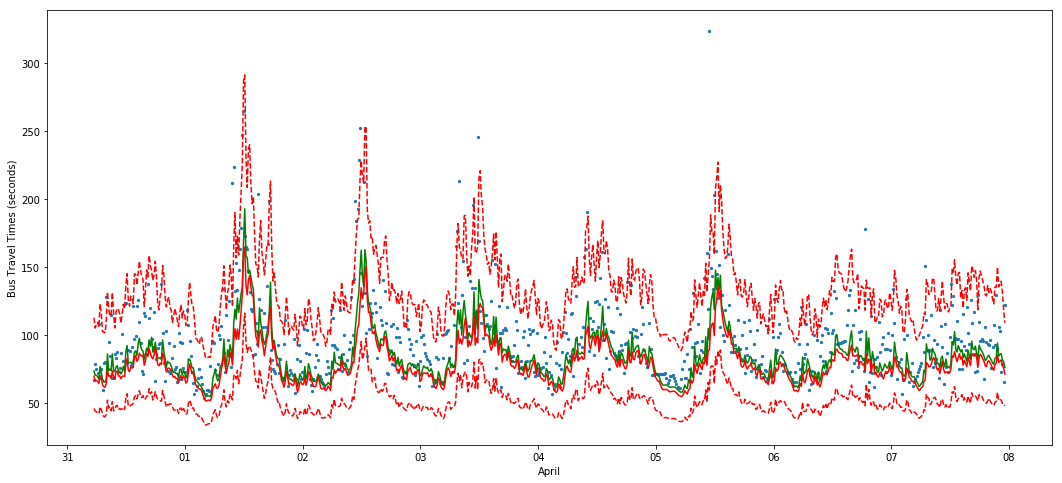

In [7]:
y_pred_mean = y_pred[:,0]
y_pred_lwr  = y_pred[:,1]
y_pred_med  = y_pred[:,2]
y_pred_upr  = y_pred[:,3]

fig, ax = plt.subplots(figsize = (18,8))
plt.ylabel("Bus Travel Times (seconds)")
plt.xlabel("April")
plt.plot(times_test, y_pred_mean, c = 'g')

ax.xaxis.set_major_formatter(DateFormatter("%d"))
plt.plot(times_test, y_pred_lwr, c = 'r', linestyle = "--")
plt.plot(times_test, y_pred_upr, c = 'r', linestyle = "--")
plt.plot(times_test, y_pred_med, c = 'r')
plt.scatter(times_test, y_test, s = 5)
plt.show()

# "Non-Deep" Quantile Regression

In [ ]:
## Reshape to "normal"
X_train = X_train[:,:,0]
y_train = y_train[:,:,0]
X_test  = X_test[:,:,0]
y_test  = y_test[:,:,0]

qr = QuantReg(y_train, X_train)
mod_median = qr.fit(q = 0.5)
mod_lwr    = qr.fit(q = 0.025)
mod_upr    = qr.fit(q = 0.975)

y_pred_median = mod_median.predict(X_test)
y_pred_lwr    = mod_lwr.predict(X_test)
y_pred_upr    = mod_upr.predict(X_test)

corr, mae, mse, rae, rmse, r2 = load.compute_error(y_test[:,0], y_pred_median)
icp, mil, rmil, clc = load.eval_quantiles(y_pred_lwr, y_pred_upr, y_test[:,0], y_pred_median)

print("Baseline Quantile regression")
print("CORR = ", "%.2f" % corr, "MAE = ", "%.2f" % mae, "MSE =", "%.2f" % mse, "RAE = ", "%.2f" % rae, "RMSE = ", "%.2f" % rmse, "R2 = ", "%.2f" % r2)
print("ICP = ", "%.2f" % icp, "MIL = ", "%.2f" % mil, "RMIL =", "%.2f" % rmil, "CLC = ", "%.2f" % clc, "\n")